# 此版本为选择200个训练样本的版本

In [1]:
import pathlib,random
import scipy.io as sio
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os

In [2]:
# 数据标准化
def max_min(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [3]:
# 定义所有常数    
# 这里完成获取数据操作
BATCHSZ = 32
train_num = 200
seed = 666
data_name = r'Salinas_corrected'
data_gt_name = r'Salinas'
result = 'result'
fix_seed = False
cube_size = 1
data_dict = sio.loadmat(r"E:\Eric_HSI\hyperspectral_datasets\Salinas_corrected.mat")
data_gt_dict = sio.loadmat(r"E:\Eric_HSI\hyperspectral_datasets\Salinas_gt.mat")

# startswith 检查字符串是否以 "————" 开头, 取出数据集
data_name = [t for t in list(data_dict.keys()) if not t.startswith('__')][0]
data_gt_name = [t for t in list(data_gt_dict.keys()) if not t.startswith('__')][0]

data = data_dict[data_name]

# 标准化
data = max_min(data).astype(np.float32)
data_gt = data_gt_dict[data_gt_name].astype(np.int32)

dim = data.shape[2]
print('DataSet %s shape is %s'%(data_name,data.shape))

DataSet salinas_corrected shape is (512, 217, 204)


In [4]:
data_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])

In [5]:
w_size = 1
t = w_size // 2
t

0

In [6]:
# 给出 row，col，返回 w_size 大小的cube???
# row, col 为像素值的位置索引

# 此处为1D CNN， 所定义的w_size 为 1
def neighbor_add(row, col, w_size=3):  
    t = w_size // 2
    # 初始化立方体 shape = 1, 1, 204
    cube = np.zeros(shape=[w_size, w_size, data.shape[2]])
    for i in range(-t, t + 1):
        for j in range(-t, t + 1):
            # 如果创建的 cube 在图像之外
            if i + row < 0 or i + row >= data.shape[0] or j + col < 0 or j + col >= data.shape[1]:
                cube[i + t, j + t] = data[row, col]
            else:
                cube[i + t, j + t] = data[i + row, j + col]
    return cube

# 得到全部用于预测的数据,除去0，不用分类

In [7]:
# 这个时分类版本 
class_num = np.max(data_gt)    
data_pos = {i: [] for i in range(1, class_num + 1)}
print(data_pos)

for i in range(data_gt.shape[0]):
    for j in range(data_gt.shape[1]):
        for k in range(1, class_num + 1):
            if data_gt[i, j] == k:
                data_pos[k].append([i, j])

data_t = 0
data_pos_all = list()

for k,v in data_pos.items():
    print('data-ID %s: %s'%(k,len(v)))
    data_t += len(v)
    for t in v:
        data_pos_all.append([k,t])
print('total data %s'%data_t)

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: []}
data-ID 1: 2009
data-ID 2: 3726
data-ID 3: 1976
data-ID 4: 1394
data-ID 5: 2678
data-ID 6: 3959
data-ID 7: 3579
data-ID 8: 11271
data-ID 9: 6203
data-ID 10: 3278
data-ID 11: 1068
data-ID 12: 1927
data-ID 13: 916
data-ID 14: 1070
data-ID 15: 7268
data-ID 16: 1807
total data 54129


In [8]:
# 这个是未分类版本
class_num = np.max(data_gt)
data_pos = {i: [] for i in range(1, 2)}
print(data_pos)

for i in range(data_gt.shape[0]):
    for j in range(data_gt.shape[1]):
        if data_gt[i, j]:
            data_pos[1].append([i, j])
data_t = 0
data_pos_all = list()

for k,v in data_pos.items():
    print('data-ID %s: %s'%(k,len(v)))
    data_t += len(v)
    for t in v:
        data_pos_all.append([k,t])
print('total data %s'%data_t)

{1: []}
data-ID 1: 54129
total data 54129


In [9]:
# 创建一个空的ndarray 用于装数据
data_all = np.zeros((54129, 1, 1, 204))
data_label_all = np.zeros((54129)).astype("int")

In [10]:
k = 0
for i in data_pos_all:
    # print(i)
    # 取出训练集中的一个数，随着 i 的改变， 所取的数也会发生改变
    [r,c] = i[1]
    # print(i[1])
    # print(r, c)
    # pixel_t = neighbor_add(r,c,w_size=cube_size).astype(np.float32).tostring()
    pixel_t = neighbor_add(r,c,w_size=cube_size).astype(np.float32)
    data_all[k] = pixel_t
    # print(pixel_t.shape)
    # print(train[1000])
    
    # 标签值 - 1
    label_t = np.array(np.array(i[0] - 1).astype(np.int64))
    data_label_all[k] = label_t
    k = k+ 1


data_all.shape, data_label_all.shape

((54129, 1, 1, 204), (54129,))

# 得到训练集和测试集

In [11]:
# 得到类别数 16类，从1开始
# DataSet salinas_corrected shape is (512, 217, 204)
# 在这里已经把标签为 0 的背景给删除了

class_num = np.max(data_gt)    

data_pos = {i: [] for i in range(1, class_num + 1)}
train_pos = {i: [] for i in range(1, class_num + 1)}
test_pos = {i: [] for i in range(1, class_num + 1)}

print(data_pos)

for i in range(data_gt.shape[0]):
    for j in range(data_gt.shape[1]):
        for k in range(1, class_num + 1):
            if data_gt[i, j] == k:
                data_pos[k].append([i, j])

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: []}


In [12]:
data_pos.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [13]:
for k, v in data_pos.items():
    print(k, end=",")

print()
for k, v in data_pos.items():
    print(len(v), end=",")

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
2009,3726,1976,1394,2678,3959,3579,11271,6203,3278,1068,1927,916,1070,7268,1807,

In [14]:
# 是否用随机种子
if fix_seed:
    random.seed(seed)

# 划分训练集和测试集, 一共 3200 个
for k, v in data_pos.items():
    if len(v)<train_num:
        train_num = 15
    else:
        train_num = train_num
    train_pos[k] = random.sample(v, int(train_num))
    test_pos[k] = [i for i in v if i not in train_pos[k]]

In [15]:
len(train_pos.items())

16

In [16]:
train_pos_all = list()
test_pos_all = list()
for k,v in train_pos.items():
    for t in v:
        train_pos_all.append([k,t])
for k,v in test_pos.items():
    for t in v:
        test_pos_all.append([k,t])

In [17]:
train_pos_all[:10]

[[1, [283, 5]],
 [1, [244, 39]],
 [1, [270, 13]],
 [1, [290, 0]],
 [1, [279, 4]],
 [1, [263, 26]],
 [1, [252, 24]],
 [1, [237, 80]],
 [1, [264, 12]],
 [1, [251, 42]]]

In [18]:
[r,c] = train_pos_all[3199]
print(r)
print(c)

16
[503, 12]


In [19]:
train_t = 0
test_t = 0
for (k1,v1),(k2,v2) in zip(train_pos.items(), test_pos.items()):
    print('traindata-ID %s: %s; testdata-ID %s: %s'%(k1,len(v1),k2,len(v2)))
    train_t += len(v1)
    test_t += len(v2)
print('total train %s, total test %s'%(train_t,test_t))
# for k,v in self.test_pos.items():
#     print('testdata-ID %s: %s'%(k,len(v)))

traindata-ID 1: 200; testdata-ID 1: 1809
traindata-ID 2: 200; testdata-ID 2: 3526
traindata-ID 3: 200; testdata-ID 3: 1776
traindata-ID 4: 200; testdata-ID 4: 1194
traindata-ID 5: 200; testdata-ID 5: 2478
traindata-ID 6: 200; testdata-ID 6: 3759
traindata-ID 7: 200; testdata-ID 7: 3379
traindata-ID 8: 200; testdata-ID 8: 11071
traindata-ID 9: 200; testdata-ID 9: 6003
traindata-ID 10: 200; testdata-ID 10: 3078
traindata-ID 11: 200; testdata-ID 11: 868
traindata-ID 12: 200; testdata-ID 12: 1727
traindata-ID 13: 200; testdata-ID 13: 716
traindata-ID 14: 200; testdata-ID 14: 870
traindata-ID 15: 200; testdata-ID 15: 7068
traindata-ID 16: 200; testdata-ID 16: 1607
total train 3200, total test 50929


In [20]:
# 创建一个空的ndarray 用于装数据
train = np.zeros((3200, 1, 1, 204)).astype(np.float32)
train_label = np.zeros((3200)).astype(np.int64)

test = np.zeros((50929, 1, 1, 204)).astype(np.float32)
test_label = np.zeros((50929)).astype(np.int64)

In [21]:
train.shape

(3200, 1, 1, 204)

In [22]:
train[3199] = np.ones((1,1,204))
train.shape, train[1].shape

((3200, 1, 1, 204), (1, 1, 204))

In [23]:
train_label[i]

0

In [24]:
# train data
k = 0
for i in train_pos_all:
    # print(i)
    # 取出训练集中的一个数，随着 i 的改变， 所取的数也会发生改变
    [r,c] = i[1]
    # print(i[1])
    # print(r, c)
    # pixel_t = neighbor_add(r,c,w_size=cube_size).astype(np.float32).tostring()
    pixel_t = neighbor_add(r,c,w_size=cube_size).astype(np.float32)
    train[k] = pixel_t
    # print(pixel_t.shape)
    # print(train[1000])
    
    # 标签值 - 1
    label_t = np.array(np.array(i[0] - 1).astype(np.int64))
    train_label[k] = label_t
    k = k+ 1

In [25]:
# test data
k = 0
for i in test_pos_all:
    # 取出测试集中的一个数，随着 i 的改变， 所取的数也会发生改变
    [r, c] = i[1]
    # pixel_t = neighbor_add(r,c,w_size=cube_size).astype(np.float32).tostring()
    pixel_t = neighbor_add(r,c,w_size=cube_size).astype(np.float32)
    test[k] = pixel_t

    label_t = np.array(np.array(i[0] - 1).astype(np.int64))
    test_label[k] = label_t
    # print('.', end='')
    k = k+ 1

In [26]:
train.shape, test.shape, train_label.shape, test.shape

((3200, 1, 1, 204), (50929, 1, 1, 204), (3200,), (50929, 1, 1, 204))

In [27]:
train.shape, train_label.shape, test.shape, test_label.shape

((3200, 1, 1, 204), (3200,), (50929, 1, 1, 204), (50929,))

In [28]:
train = np.expand_dims(train, 4)
test = np.expand_dims(test, 4)

In [29]:
train.shape, train_label.shape, test.shape, test_label.shape

((3200, 1, 1, 204, 1), (3200,), (50929, 1, 1, 204, 1), (50929,))

In [30]:
# 创建dataset
db_train = tf.data.Dataset.from_tensor_slices((train, train_label))
db_test = tf.data.Dataset.from_tensor_slices((test, test_label))

db_train = db_train.shuffle(3800).batch(batch_size=BATCHSZ).repeat()
db_test = db_test.batch(batch_size=BATCHSZ)

In [31]:
db_train, db_test

(<RepeatDataset shapes: ((None, 1, 1, 204, 1), (None,)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((None, 1, 1, 204, 1), (None,)), types: (tf.float32, tf.int64)>)

In [32]:
train[1].shape

(1, 1, 204, 1)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(input_shape=train[1].shape, filters=32, kernel_size=(1, 1, 8), strides=(1, 1, 3), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(filters=64, kernel_size=(1, 1, 8), strides=(1, 1, 3), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(filters=128, kernel_size=(1, 1, 8), strides=(1, 1, 3), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax'),
])

In [34]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=10, min_lr=0.000001, verbose=1)

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001),  # 优化器的选择
             loss='sparse_categorical_crossentropy',
              metrics=['acc']
             )

In [36]:
BATCHSZ = 32

In [37]:
train.shape[0]

3200

In [38]:
history = model.fit(db_train,
                    batch_size=BATCHSZ, 
                    steps_per_epoch=3200//BATCHSZ,
                    epochs=10, 
                    validation_data=db_test,
                    validation_steps=50929//BATCHSZ,
                    callbacks=[reduce_lr]
                    )

Epoch 1/10
100/100 [==============================] - 2s 22ms/step - loss: 1.0263 - acc: 0.6156 - val_loss: 3.5697 - val_acc: 0.0339
Epoch 2/10
100/100 [==============================] - 2s 19ms/step - loss: 0.5712 - acc: 0.7763 - val_loss: 6.1933 - val_acc: 0.0339
Epoch 3/10
100/100 [==============================] - 2s 19ms/step - loss: 0.4994 - acc: 0.8062 - val_loss: 7.8116 - val_acc: 0.0339
Epoch 4/10
 88/100 [=========================>....] - ETA: 0s - loss: 0.4173 - acc: 0.8303

KeyboardInterrupt: 

In [60]:
test = db_test
acc_num,test_num = 0,0
matrix = np.zeros((class_num,class_num),dtype=np.int64)

target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']

def reports(test,test_label):
    Y_pred_label = model.predict(test)
    # 概率最大的值的位置就为预测的类别
    y_pred_label = np.argmax(Y_pred_label, axis=1)

    # 分类报告：precision    recall  f1-score   support
    classification = classification_report(test_label, y_pred_label, target_names=target_names)
    # 混淆矩阵
    confusion = confusion_matrix(test_label, y_pred_label)
    # 模型得分
    score = model.evaluate(test, test_label, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy

In [61]:
# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy = reports(test,test_label)
classification = str(classification)
confusion_str = str(confusion)

1592/1592 [==============================] - 2s 1ms/step - loss: 1.4006 - acc: 0.5147


In [62]:
file_name = "./result/report.txt"
with open(file_name, 'w') as x_file:
    x_file.write('Test loss {} (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write(" classification result: \n")
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write(" confusion matrix: \n")
    x_file.write('{}'.format(confusion_str))

In [63]:
ac_list = []
matrix = confusion
for i in range(len(matrix)):
    ac = matrix[i, i] / sum(matrix[:, i])
    ac_list.append(ac)
    print(i+1,'class:','(', matrix[i, i], '/', sum(matrix[:, i]), ')', ac)
print('confusion matrix:')
print(np.int_(matrix))
print('total right num:', np.sum(np.trace(matrix)))
accuracy = np.sum(np.trace(matrix)) / np.sum(matrix)
print('oa:', accuracy)
# kappa
kk = 0
for i in range(matrix.shape[0]):
    kk += np.sum(matrix[i]) * np.sum(matrix[:, i])
pe = kk / (np.sum(matrix) * np.sum(matrix))
pa = np.trace(matrix) / np.sum(matrix)
kappa = (pa - pe) / (1 - pe)
ac_list = np.asarray(ac_list)
aa = np.mean(ac_list)
oa = accuracy
print('aa:',aa)
print('kappa:', kappa)

1 class: ( 1680 / 1680 ) 1.0
2 class: ( 3478 / 4155 ) 0.8370637785800241
3 class: ( 6 / 1407 ) 0.0042643923240938165
4 class: ( 711 / 717 ) 0.9916317991631799
5 class: ( 25 / 494 ) 0.05060728744939271
6 class: ( 3758 / 4858 ) 0.7735693701111569
7 class: ( 1182 / 1182 ) 1.0
8 class: ( 7626 / 12291 ) 0.6204539907249207
9 class: ( 2696 / 3383 ) 0.7969258054980787
10 class: ( 1074 / 6149 ) 0.17466254675557003
11 class: ( 864 / 9532 ) 0.09064204783885858
12 class: ( 0 / 0 ) nan
13 class: ( 0 / 1 ) 0.0
14 class: ( 44 / 945 ) 0.04656084656084656
15 class: ( 1519 / 2565 ) 0.5922027290448343
16 class: ( 1551 / 1570 ) 0.9878980891719745
confusion matrix:
[[1680  129    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 3478    0    0    0   43    0    0    0    0    0    0    0    0
     0    5]
 [   0    0    6    0    4    0    0    0  128    0 1638    0    0    0
     0    0]
 [   0    0   17  711  465    0    0    0    0    0    1    0    0    0
     0    0]
 [   0 

# 绘图

In [42]:
height = 512
width = 217
outputs = np.zeros((height,width))

In [45]:
import time

In [48]:
# calculate the predicted image， 非常慢
starttime = time.time()

k = 0
for i in range(height):
    for j in range(width): 
        # target = labels[i][j]
        if data_gt[i][j] == 0:
            continue
        else:
            prediction = np.argmax(model.predict(data_all[k].reshape(1, 1, 1, 204, 1)), axis=-1)
            k += 1
            outputs[i][j] = prediction+1
            # print(prediction)

endtime = time.time()
dtime = endtime - starttime
print("程序运行时间：%.8s s" % dtime)  #显示到微秒

程序运行时间：1580.274 s


In [49]:
prediction = np.argmax(model.predict(data_all[2000].reshape(1, 1, 1, 204, 1)), axis=-1)
list(prediction)

[2]

In [50]:
outputs

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [16., 16., 16., ...,  0.,  0.,  0.],
       [16., 16., 16., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [51]:
import spectral

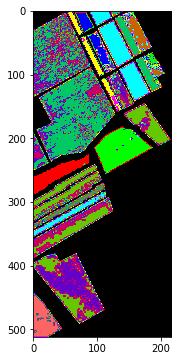

In [52]:
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(6, 6))

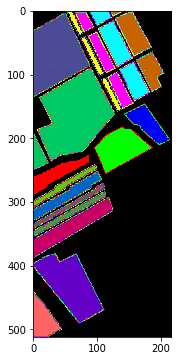

In [53]:
ground_truth = spectral.imshow(classes=data_gt, figsize=(6, 6))

# 对比一下两种获取方式得到的最终速度

In [ ]:
import time

In [ ]:
starttime = time.time()

height = 100
width = 100
k = 0
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width): 
        for k in range(10000):
            outputs[i][j] = 1

endtime = time.time()
dtime = endtime - starttime
print("程序运行时间：%.8s s" % dtime)  #显示到微秒

In [ ]:
outputs

In [ ]:
starttime = time.time()

outputs = list()
for i in range(height):
    for j in range(width): 
        outputs.append(2)
outputs = np.array(outputs).reshape((height,width))
endtime = time.time()
dtime = endtime - starttime
print("程序运行时间：%.8s s" % dtime)  #显示到微秒

In [ ]:
outputs